In [1]:
%load_ext autoreload
%autoreload 2

In [6]:
import torch
import torch.nn as nn
from datasets import SineDataset, CosineDataset, SineCosineDataset
from datasets.sine_cosine import SineSuperResDataset, CosineSuperResDataset
from torch.utils.data import ConcatDataset, DataLoader
from tiny.diffusion import Diffusion
from tiny.models import SuperResPointCloudDiT
from tqdm import tqdm
import matplotlib.pyplot as plt

In [7]:
import torch

def collate_fn(batch):
    """ Collate function for handling dictionaries with arbitrary keys, including string handling.

    Args:
        batch (list): A list of dictionaries. Each dictionary represents a sample from the dataset.

    Returns:
        dict: A dictionary with the same keys as the input dictionaries, where the values are batches combined appropriately.
    """
    # Initialize an empty dict to collect the batches
    collated_batch = {}

    # Each sample in the batch is a dictionary. We iterate over the keys of the first sample
    # to get all the keys assuming all samples have the same structure.
    for key in batch[0].keys():
        # Collect values from all dictionaries under the same key
        values = [sample[key] for sample in batch]

        # Check the type of the first element to decide how to combine
        if isinstance(values[0], torch.Tensor):
            # If the value is a tensor, stack them
            collated_batch[key] = torch.stack(values)
        elif isinstance(values[0], (int, float)):
            # If the value is numeric, convert to tensor
            collated_batch[key] = torch.tensor(values)
        elif isinstance(values[0], list):
            # If the value is a list, convert lists to tensor
            try:
                # Try to convert lists directly to a tensor
                collated_batch[key] = torch.tensor(values)
            except ValueError:
                # If direct conversion fails, handle as a list of tensors
                collated_batch[key] = [torch.tensor(v) for v in values]
        elif isinstance(values[0], str):
            # If the value is a string, collect into a list
            collated_batch[key] = values
        else:
            # Implement other types as needed or raise an error
            raise TypeError(f"Unsupported data type for batch collation: {type(values[0])}")

    return collated_batch


In [8]:
def plot_point_clouds(point_clouds: torch.Tensor, rows: int, cols: int):
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))
    axes = axes.ravel()
    dim = point_clouds.shape[2]
    point_clouds = point_clouds.cpu()

    for idx, ax in enumerate(axes):
        if idx < len(point_clouds):

            if dim == 2:
                X, Y = point_clouds[idx, :, 0], point_clouds[idx, :, 1]
                ax.scatter(X, Y)
            elif dim == 3:
                X, Y, Z = (
                    point_clouds[idx, :, 0],
                    point_clouds[idx, :, 1],
                    point_clouds[idx, :, 2],
                )
                ax.scatter(X, Y, Z)

            ax.axis("equal")  # Ensures that the scale of x and y axes are the same
        else:
            ax.axis("off")  # Turn off axis if there's no data to plot

def count_parameters(model: nn.Module):
    return sum(p.numel() for p in model.parameters())

In [13]:
num_points = 512
low_res_points = 32
# dataset = SineCosineDataset(num_points=num_points, size=1024)

sine_dataset = SineSuperResDataset(num_points=num_points, low_res_points=low_res_points, size=15000)
cosine_dataset = CosineSuperResDataset(num_points=num_points, low_res_points=low_res_points, size=15000)
dataset = ConcatDataset([sine_dataset, cosine_dataset])

dataloader = DataLoader(dataset, collate_fn=collate_fn, batch_size=128, shuffle=True)

In [14]:
diffusion = Diffusion(
    schedule_type="linear",
    num_timesteps=1000
)

model = SuperResPointCloudDiT(input_size=num_points, low_res_size=low_res_points, in_channels=2, depth=1, num_heads=1, hidden_size=32).to("cuda")

count_parameters(model)

26660

In [15]:
model(torch.randn(1, num_points, 2).to("cuda"), torch.tensor([0]).to("cuda"), torch.zeros(1, low_res_points, 2).to("cuda")).shape

torch.Size([1, 512, 2])

In [16]:
num_epochs = 20
model = model.to("cuda")
diffusion = diffusion.to("cuda")
model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

with tqdm(total=num_epochs * len(dataloader)) as pbar:
    for epoch in range(num_epochs):
        for batch in dataloader:

            high_res = batch["high_res"].to("cuda")
            low_res = batch["low_res"].to("cuda")
        
            t = torch.randint(0, 1000, (high_res.shape[0],)).long().to("cuda")
            loss = diffusion.training_losses(model, high_res, t, cond=low_res)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            pbar.update(1)
            pbar.set_postfix({"loss": loss.item()})

  0%|          | 1/4700 [00:00<09:12,  8.51it/s, loss=1]

100%|██████████| 4700/4700 [01:22<00:00, 57.22it/s, loss=0.166] 


In [19]:
cond = cosine_dataset[0]["low_res"].unsqueeze(0).repeat(100, 1, 1).to("cuda")
cond.shape

torch.Size([100, 32, 2])

  2%|▏         | 23/1000 [00:00<00:04, 221.43it/s]

100%|██████████| 1000/1000 [00:04<00:00, 211.40it/s]


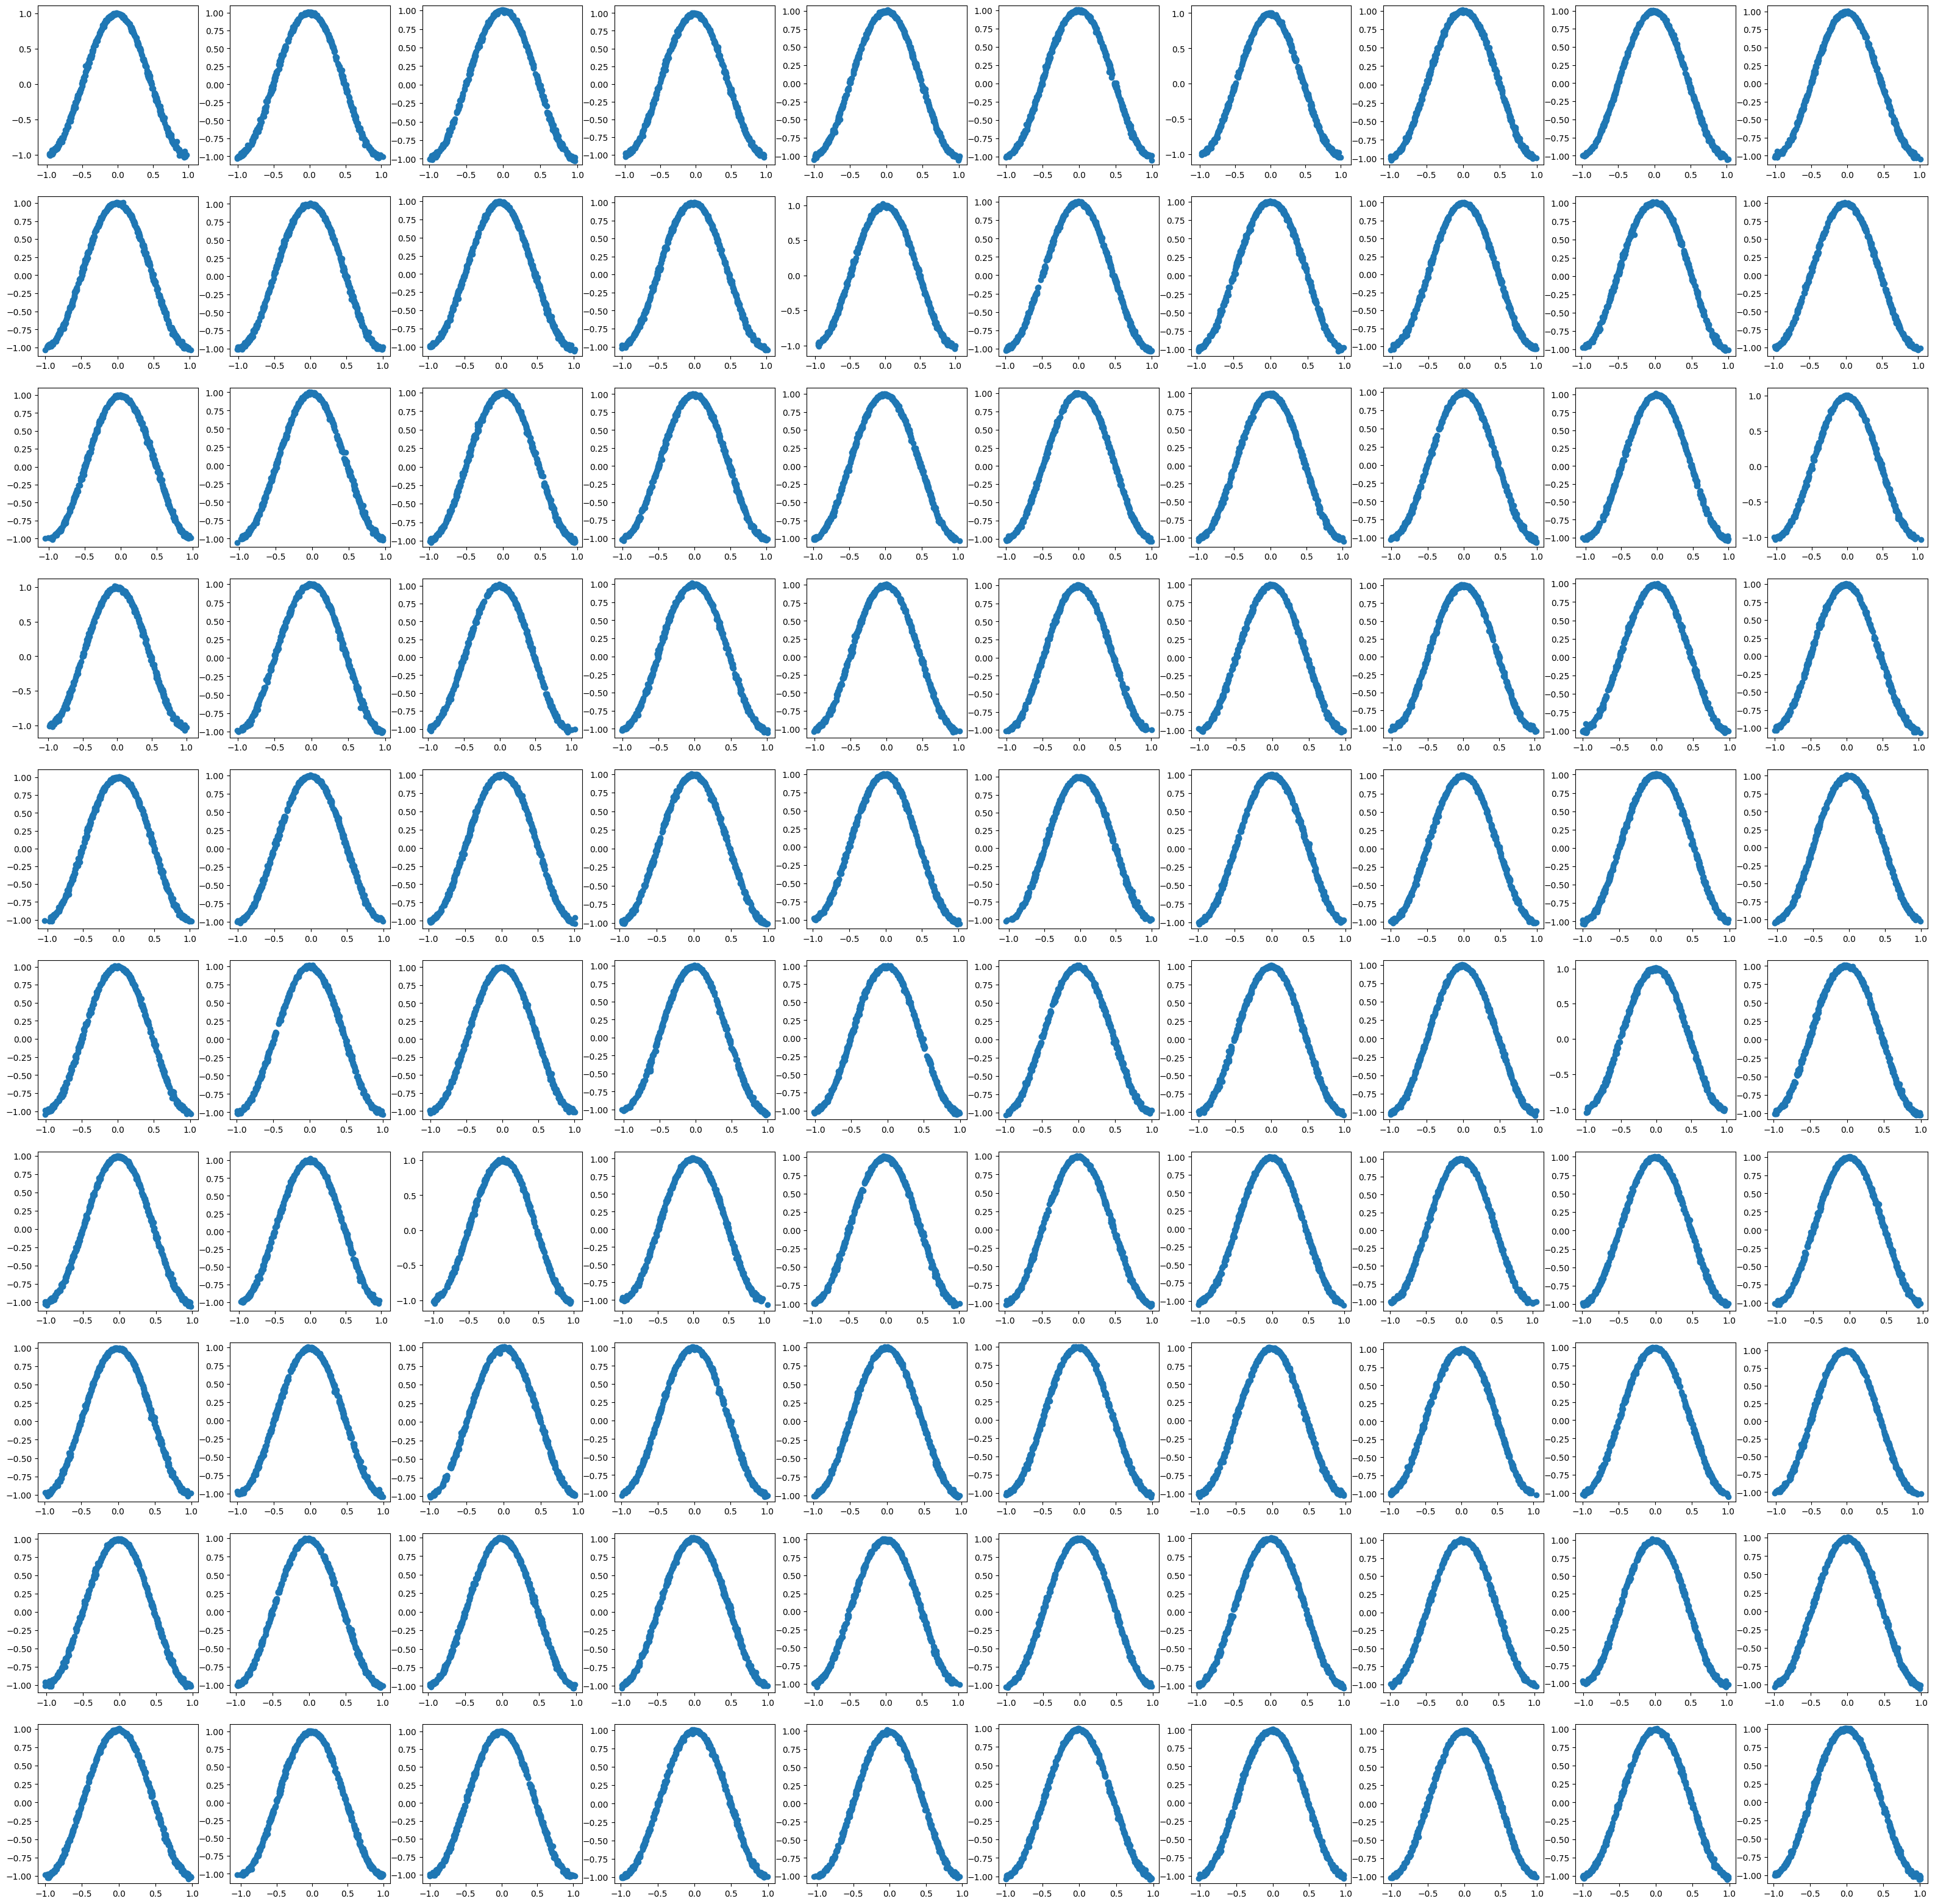

In [20]:
samples = diffusion.p_sample_loop(model, (100, num_points, 2), low_res=cond, clip_denoised=False)
# samples = diffusion.p_sample_loop(model, (100, num_points, 2), cond=torch clip_denoised=False)
plot_point_clouds(samples, 10, 10)